In [91]:
import numpy as np
import numba as nb
import os
import matplotlib.pyplot as plt

#### The following code calculates $g_*$ and $g_{*s}$ for after the QCD transition. (?)


First there is a list of all the particles that have masses below $1$ GeV. The fermion and boson matrices categorize these particles by type as well as saving their $g$ value. Then there are integrands for fermions/bosons for $g_*$ and for $g_{*s}$

Functions for calculating $g_*$:

- $\bf{rho}$ calculates the energy density of particles with mass $m$ and value $g$
- $\bf{density}$ calculates the energy density for all of the particles in the fermion and boson matrices
- $\bf{gstar}$ calculates $g_*$ lol obviously

Functions for calculating $g_{*s}$:

- $\bf{P}$ calculates the pressure given mass $m$ and value $g$
- $\bf{pressure}$ calculates the pressure for all of the particles in the fermion and boson matrices
- $\bf{entropy}$ calculates the entropy for all of the particles in the fermion and boson matrices
- $\bf{gstar}$ calculates $g_{*s}$ at each temperature 


In [92]:
#mass values

#fermions
m_e = 0.511
m_mu = 105.7
m_tau = 1777
ve = 0
vmu = 0
vtau = 0
proton = 938.272
neutron = 939.565

#bosons
pion_pm = 139.57039
pion_0 = 134.9768
kaon_pm = 493.677
kaon_0 = 497.613
eta = 547.862
eta_p = 957.78
rho_pm = 775.11
rho_0 = 775.26

fermions = np.array([[mve, 2], [mvmu, 2], [mvtau, 2], [m_e, 4], [m_mu, 4], [m_tau, 4], [m_p, 4], [m_n, 4] ])
bosons = np.array([[0,2], [pion_pm, 2], [pion_0, 1], [kaon_pm, 2], [kaon_0, 2] , [eta, 1] , [eta_p, 1] , [rho_pm, 6], [rho_0, 3]])


# Calculate $g_{*}$

In [105]:
@nb.jit(nopython=True)
def g_fermion_integrand(x, m, T): 
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))+1) * np.exp(x)

@nb.jit(nopython=True)
def g_boson_integrand(x, m, T):
    return np.sqrt(x**2+(m/T)**2) * (x**2)/(np.exp(np.sqrt(x**2+(m/T)**2))-1) * np.exp(x)

x_lagauss, w_lagauss = np.polynomial.laguerre.laggauss(40)
@nb.jit(nopython=True)
def rho(m, g, T, integrand):
    rho_vals = (g/2)*T**4/np.pi**2 * integrand(x_lagauss, m, T) * w_lagauss
    return np.sum(rho_vals)

@nb.jit(nopython=True)
def density(T, mass_gf, mass_gb):
    density_val_f = 0 
    density_val_b = 0 
    for massf, gf in mass_gf:
        density_val_f += rho(massf, gf, T, g_fermion_integrand)
    for massb, gb in mass_gb:
        density_val_b += rho(massb, gb, T, g_boson_integrand)
    return density_val_f + density_val_b

@nb.jit(nopython=True)
def gstar(T, mass_gf, mass_gb):
    return 30/np.pi**2*density(T, mass_gf, mass_gb)/T**4

#print('T=10 MeV: photons+neutrinos g*=', gstar(10, fermions, bosons))
#print('T=500 MeV: photons+neutrinos g*=', gstar(500, fermions, bosons))
print('T=10 MeV: g* =', gstar(10, fermions, bosons))
print('T=180 MeV: g*=', gstar(180, fermions, bosons))
print('T=500 MeV: g*=', gstar(500, fermions, bosons))

T=10 MeV: g* = 10.759743332407645
T=180 MeV: g*= 22.302890667602526
T=500 MeV: g*= 35.72531005489991


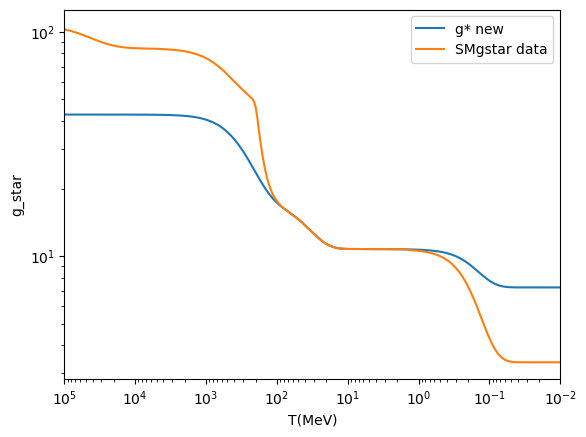

In [106]:
T = np.loadtxt("SMgstar.dat", usecols = 0, unpack = True)
gstar_old = np.loadtxt("SMgstar.dat", usecols = 1, unpack = True)
gstar_plot_vals = np.zeros(len(T))

for i in range(len(T)):
    gstar_plot_vals[i] = gstar(T[i], fermions, bosons)


plt.figure()
plt.loglog(T, gstar_plot_vals)
plt.loglog(T, gstar_old)
plt.xlim(1e5,1e-2)
plt.ylabel('g_star')
plt.xlabel('T(MeV)')
plt.legend(['g* new', 'SMgstar data'])
plt.show()

# Calculate $g_{*s}$

In [109]:
@nb.jit(nopython=True)
def gs_fermion_integrand(x, m, T):
    Ex = np.sqrt(x**2+(m/T)**2)
    return x**2/Ex * (x**2)/(np.exp(Ex)+1) * np.exp(x)

@nb.jit(nopython=True)
def gs_boson_integrand(x, m, T):
    Ex = np.sqrt(x**2+(m/T)**2)
    return x**2/Ex * (x**2)/(np.exp(Ex)-1) * np.exp(x)

x_lagauss, w_lagauss = np.polynomial.laguerre.laggauss(40)
@nb.jit(nopython=True)
def P(m, g, T, integrand): # this is the new rho funciton
    p_vals = g*T**4/(6*np.pi**2) * integrand(x_lagauss, m, T) * w_lagauss
    return np.sum(p_vals)

@nb.jit(nopython=True)
def pressure(T, mass_gf, mass_gb):
    p_vals_f = 0
    p_vals_b = 0
    for massf, gf in mass_gf:
        p_vals_f += P(massf, gf, T, gs_fermion_integrand)
    for massb, gb in mass_gb: 
        p_vals_b += P(massb, gb, T, gs_boson_integrand)
    return p_vals_f + p_vals_b

@nb.jit(nopython=True)
def entropy(T, mass_gf, mass_gb):
    S = (1/T)*(density(T, mass_gf, mass_gb) + pressure(T, mass_gf, mass_gb))
    return S
    
@nb.jit(nopython=True)    
def gstarS(T, mass_gf, mass_gb):
    return 45/(2*np.pi**2)*entropy(T, mass_gf, mass_gb)/T**3

print('T=10 MeV: g*s=', gstarS(10, fermions, bosons))
print('T=10 MeV: g*s=', gstarS(180, fermions, bosons))
print('T=10 MeV: g*s=', gstarS(500, fermions, bosons))

T=10 MeV: g*s= 10.757443582895911
T=10 MeV: g*s= 21.58647178475756
T=10 MeV: g*s= 34.707545264897796


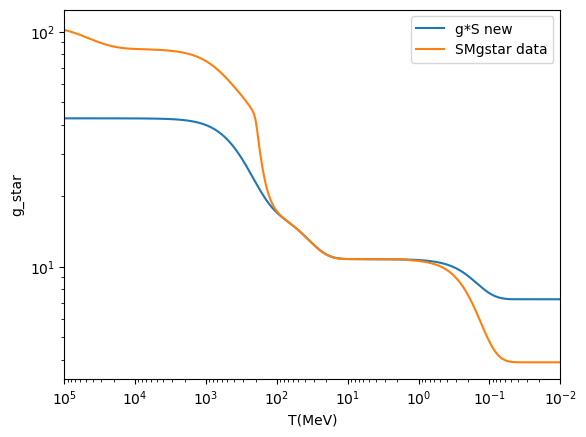

In [108]:
T = np.loadtxt("SMgstar.dat", usecols = 0, unpack = True)
gstarS_old = np.loadtxt("SMgstar.dat", usecols = 2, unpack = True)
gstarS_plot_vals = np.zeros(len(T))

for i in range(len(T)):
    gstarS_plot_vals[i] = gstarS(T[i], fermions, bosons)


plt.figure()
plt.loglog(T, gstarS_plot_vals)
plt.loglog(T, gstarS_old)
plt.xlim(1e5,1e-2)
plt.ylabel('g_star')
plt.xlabel('T(MeV)')
plt.legend(['g*S new', 'SMgstar data'])
plt.show()